# Training a RL Agent with Stable-Baselines3 Using a GEM Environment

This notebook serves as an educational introduction to the usage of Stable-Baselines3 using a gym-electric-motor (GEM) environment. The goal of this notebook is to give an understanding of what Stable-Baselines3 is and how to use it to train and evaluate a reinforcement learning agent that can solve a current control problem of the GEM toolbox.

## 1. Installation

Before you can start you need to make sure that you have both gym-electric-motor and Stable-Baselines3 installed. You can install both easily using pip:

- ```pip install gym-electric-motor```
- ```pip install stable-baselines3```

Alternatively, you can install them and their latest developer version directly from GitHub:

- https://github.com/upb-lea/gym-electric-motor
- https://github.com/DLR-RM/stable-baselines3

For this notebook, the following cell will do the job:

In [16]:
!pip install -q git+https://github.com/upb-lea/gym-electric-motor.git git+https://github.com/DLR-RM/stable-baselines3.git

## 2. Setting up a GEM Environment

The basic idea behind reinforcement learning is to create a so-called agent, that should learn by itself to solve a specified task in a given environment. 
This environment gives the agent feedback on its actions and reinforces the targeted behavior.
In this notebook, the task is to train a controller for the current control of a *permanent magnet synchronous motor* (*PMSM*).
 
In the following, the used GEM-environment is briefly presented, but this notebook does not focus directly on the detailed usage of GEM. If you are new to the used environment and interested in finding out what it does and how to use it, you should take a look at the [GEM cookbook](https://colab.research.google.com/github/upb-lea/gym-electric-motor/blob/master/examples/example_notebooks/GEM_cookbook.ipynb).

The basic idea of the control setup from the GEM-environment is displayed in the following figure. 

![](../../docs/plots/SCML_Overview.png)

The agent controls the converter who converts the supply currents to the currents flowing into the motor - for the *PMSM*: $i_{sq}$ and $i_{sd}$

In the continuous case, the agent's action equals a duty cycle which will be modulated into a corresponding voltage. 

In the discrete case, the agent's actions denote switching states of the converter at the given instant. Here, only a discrete amount of options are available. In this notebook, for the PMSM the *discrete B6 bridge converter* with six switches is utilized per default. This converter provides a total of eight possible actions.

![](../../docs/plots/B6.svg)

The motor schematic is the following:


![](../../docs/plots/ESBdq.svg)

And the electrical ODEs for that motor are:

<h3 align="center">

<!-- $\frac{\mathrm{d}i_{sq}}{\mathrm{d}t} = \frac{u_{sq}-pL_d\omega_{me}i_{sd}-R_si_{sq}}{L_q}$

$\frac{\mathrm{d}i_{sd}}{\mathrm{d}t} = \frac{u_{sd}-pL_q\omega_{me}i_{sq}-R_si_{sd}}{L_d}$

$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$
 -->

   $ \frac{\mathrm{d}i_{sd}}{\mathrm{d}t}=\frac{u_{sd} + p\omega_{me}L_q i_{sq} - R_s i_{sd}}{L_d} $ <br><br>
    $\frac{\mathrm{d} i_{sq}}{\mathrm{d} t}=\frac{u_{sq} - p \omega_{me} (L_d i_{sd} + \mathit{\Psi}_p) - R_s i_{sq}}{L_q}$ <br><br>
   $\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$

</h3>

The target for the agent is now to learn to control the currents. For this, a reference generator produces a trajectory that the agent has to follow. 
Therefore, it has to learn a function (policy) from given states, references and rewards to appropriate actions.

For a deeper understanding of the used models behind the environment see the [documentation](https://upb-lea.github.io/gym-electric-motor/).
Comprehensive learning material to RL is also [freely available](https://github.com/upb-lea/reinforcement_learning_course_materials).

In [17]:
%matplotlib notebook
import numpy as np
from pathlib import Path
import gym_electric_motor as gem
from gym_electric_motor.reference_generators import \
    MultipleReferenceGenerator,\
    WienerProcessReferenceGenerator
from gym_electric_motor.visualization import MotorDashboard
from gym_electric_motor.core import Callback
from gym.spaces import Discrete, Box
from gym.wrappers import FlattenObservation, TimeLimit
from gym import ObservationWrapper

In [18]:
# helper functions and classes

class RewardLogger(Callback):
    """Logs the reward accumulated in each episode"""
    def __init__(self):
        self._step_rewards = []
        self._mean_episode_rewards = []
        dir_path = Path.cwd() /"rl_frameworks" / "saved_agents"
        dir_path.mkdir(parents=True, exist_ok=True)
        self.fpath = dir_path  / "EpisodeRewards.npy"
        
    def on_step_end(self):
        """Stores the received reward at each step"""
        self._step_rewards.append(self._env._reward)
    
    def on_reset_begin(self):
        """Stores the mean reward received in every episode"""
        self._mean_episode_rewards.append(np.mean(self._step_rewards))
        self._step_rewards = []
        
    def on_close(self):
        """Writes the mean episode reward of the experiment to a file."""
        np.save(self.fpath, np.array(self._mean_episode_rewards))


class FeatureWrapper(ObservationWrapper):
    """
    Wrapper class which wraps the environment to change its observation. Serves
    the purpose to improve the agent's learning speed.
    
    It changes epsilon to cos(epsilon) and sin(epsilon). This serves the purpose
    to have the angles -pi and pi close to each other numerically without losing
    any information on the angle.
    
    Additionally, this wrapper adds a new observation i_sd**2 + i_sq**2. This should
    help the agent to easier detect incoming limit violations.
    """

    def __init__(self, env, epsilon_idx, i_sd_idx, i_sq_idx):
        """
        Changes the observation space to fit the new features
        
        Args:
            env(GEM env): GEM environment to wrap
            epsilon_idx(integer): Epsilon's index in the observation array
            i_sd_idx(integer): I_sd's index in the observation array
            i_sq_idx(integer): I_sq's index in the observation array
        """
        super(FeatureWrapper, self).__init__(env)
        self.EPSILON_IDX = epsilon_idx
        self.I_SQ_IDX = i_sq_idx
        self.I_SD_IDX = i_sd_idx
        new_low = np.concatenate((self.env.observation_space.low[
                                  :self.EPSILON_IDX], np.array([-1.]),
                                  self.env.observation_space.low[
                                  self.EPSILON_IDX:], np.array([0.])))
        new_high = np.concatenate((self.env.observation_space.high[
                                   :self.EPSILON_IDX], np.array([1.]),
                                   self.env.observation_space.high[
                                   self.EPSILON_IDX:],np.array([1.])))

        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation. Adds the new features to the
        observation and removes original epsilon.
        
        """
        cos_eps = np.cos(observation[self.EPSILON_IDX] * np.pi)
        sin_eps = np.sin(observation[self.EPSILON_IDX] * np.pi)
        currents_squared = observation[self.I_SQ_IDX]**2 + observation[self.I_SD_IDX]**2
        observation = np.concatenate((observation[:self.EPSILON_IDX],
                                      np.array([cos_eps, sin_eps]),
                                      observation[self.EPSILON_IDX + 1:],
                                      np.array([currents_squared])))
        return observation

In [19]:
# define motor arguments
motor_parameter = dict(
    p=3,  # [p] = 1, nb of pole pairs
    r_s=17.932e-3,  # [r_s] = Ohm, stator resistance
    l_d=0.37e-3,  # [l_d] = H, d-axis inductance
    l_q=1.2e-3,  # [l_q] = H, q-axis inductance
    psi_p=65.65e-3,  # [psi_p] = Vs, magnetic flux of the permanent magnet
)
# supply voltage
u_supply = 350

# nominal and absolute state limitations
nominal_values=dict(
    omega=4000*2*np.pi/60,
    i=230,
    u=u_supply
)
limit_values=dict(
    omega=4000*2*np.pi/60,
    i=1.5*230,
    u=u_supply
)

# sampling interval
tau = 1e-5

# define maximal episode steps
max_eps_steps = 10000


motor_initializer={'random_init': 'uniform', 'interval': [[-230, 230], [-230, 230], [-np.pi, np.pi]]}
reward_function=gem.reward_functions.WeightedSumOfErrors(
    reward_weights={'i_sq': 10, 'i_sd': 10},
    gamma=0.99,  # discount rate 
    reward_power=1
)


# creating gem environment
env = gem.make(  # define a PMSM with discrete action space
    "Finite-CC-PMSM-v0",
    # visualize the results
    visualization=MotorDashboard(state_plots=['i_sq', 'i_sd'], reward_plot=True),
    
    # parameterize the PMSM and update limitations
    motor=dict(
        motor_parameter=motor_parameter,
        limit_values=limit_values,
        nominal_values=nominal_values,
        motor_initializer=motor_initializer,
    ),
    # define the random initialisation for load and motor
    load=dict(
        load_initializer={'random_init': 'uniform', },
    ),
    reward_function=reward_function,
    supply=dict(u_sup=u_supply),
    # define the duration of one sampling step
    tau=tau,
    
    ode_solver='euler',
)

# remove one action from the action space to help the agent speed up its training
# this can be done as both switchting states (1,1,1) and (-1,-1,-1) - which are encoded
# by action 0 and 7 - both lead to the same zero voltage vector in alpha/beta-coordinates
env.action_space = Discrete(7)

# applying wrappers
eps_idx = env.physical_system.state_names.index('epsilon')
i_sd_idx = env.physical_system.state_names.index('i_sd')
i_sq_idx = env.physical_system.state_names.index('i_sq')
env = TimeLimit(
    FeatureWrapper(
        FlattenObservation(env), 
        eps_idx, i_sd_idx, i_sq_idx
    ),
    max_eps_steps
)

/home/wilhelmk/tools/anaconda3/envs/tf-cpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 3. Training an Agent with Stable-Baselines3

Stable-Baselines3 collects Reinforcement Learning algorithms implemented in Pytorch. 

Stable-Baselines3 is still a very new library with its current release being 0.9. That is why its collection of algorithms is not very large yet and most algorithms lack more advanced variants. However, its authors planned to broaden the available algorithms in the future. For currently available algorithms see their [documentation](https://stable-baselines3.readthedocs.io/en/master/guide/rl.html).

To use an agent provided by Stable-Baselines3 your environment has to have a [gym interface](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html). 

### 3.1 Imports

The environment in this control problem poses a discrete action space. Therefore, the [Deep Q-Network (DQN)](https://arxiv.org/abs/1312.5602) is a suitable agent.
For the specific implementation of the DQN you can refer to [Stable-Baslines3's docs](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html).

In this tutorial a multi-layer perceptron (MLP) is used. For this you have to import the DQN and the MlpPolicy. You can also see in the docs which gym spaces for the observation and the actions are supported. You might have to take that into account for your environment.

In [20]:
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy
from pathlib import Path

### 3.2 Setting the parameters

For the DQN algorithm you have to define a set of parameters. The policy_kwargs dictionary is a parameter which is directly given to the MlpPolicy. The net_arch key defines the network architecture of the MLP.

In [21]:
buffer_size = 200000 #number of old obsersation steps saved
learning_starts = 10000 # memory warmup
train_freq = 1 # prediction network gets an update each train_freq's step
batch_size = 25 # mini batch size drawn at each update step
policy_kwargs = {
        'net_arch': [64,64] # hidden layer size of MLP
        }
exploration_fraction = 0.1 # Fraction of training steps the epsilon decays 
target_update_interval = 1000 # Target network gets updated each target_update_interval's step
gamma = 0.99
verbose = 1 # verbosity of stable-basline's prints

Additionally, you have to define how long your agent shall train. You can just set a concrete number of steps or use knowledge of the environment's temporal resolution to define an in-simulation training time. In this example, the agent is trained for five seconds which translates in this environment's case to 500000 steps.

In [22]:
tau = 1e-5
simulation_time = 5 # seconds
nb_steps = int(simulation_time // tau)

### 3.3 Starting the training

Once you've setup the environment and defined your parameters starting the training is nothing more than a one-liner. For each algorithm all you have to do is call its ```learn()``` function. However, you should note that the execution of the training can take a long time. Currently, Stable-Baselines3 does not provide any means of saving the training reward for later visualization. Therefore, a ```RewardLogger``` callback is used for this environment (see code a few cells above).

In [23]:
model = DQN(MlpPolicy, env, buffer_size=buffer_size, learning_starts=learning_starts ,train_freq=train_freq, 
            batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs, 
            exploration_fraction=exploration_fraction, target_update_interval=target_update_interval,
            verbose=verbose)
model.learn(total_timesteps=nb_steps)

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.942    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4141     |
|    time_elapsed     | 0        |
|    total timesteps  | 3034     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.06     |
|    n_updates        | 489999   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.821    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4237     |
|    time_elapsed     | 2        |
|    total timesteps  | 9424     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.781    |
| time/               |          |
|    episodes         | 12       |
|  

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 80       |
|    fps              | 672      |
|    time_elapsed     | 511      |
|    total timesteps  | 344144   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.09     |
|    n_updates        | 334143   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 84       |
|    fps              | 664      |
|    time_elapsed     | 541      |
|    total timesteps  | 359499   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.24     |
|    n_updates        | 349498   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rat

### 3.4 Saving the Model

When the training has finished you can save the model your DQN has learned to reuse it later, e.g. for evaluation or if you want to continue your training. For this, each Stable-Baselines3 algorithm has a ```.save()``` function where you only have to specify your path.

In [24]:
log_path = Path.cwd() / "saved_agents" 
log_path.mkdir(parents=True, exist_ok=True)
model.save(str(log_path / "TutorialAgent"))

## 4. Evaluating an Agent

After you have trained your agent you would like to see how well it does on your control problem. For this you can look at a visual representation of your currents in a test trajectory or see how well your agent does in a test scenario.

### 4.1 Loading a Model (Optional)

First, before you start your evaluation you have to load a trained agent or take the trained agent from above which is still saved in the variable ```model```. To load a trained agent you simply have to call the ```load()``` function of your algorithm with the respective path.

In [25]:
model = DQN.load(log_path / 'TutorialAgent')  #your agent

### 4.2 Taking a Look at the Mean Reward per Episode During Training

The ```RewardLogger``` callback saved the mean reward per episode during training. There you can observe how the training reward did grow over time and if any problems occured during training.

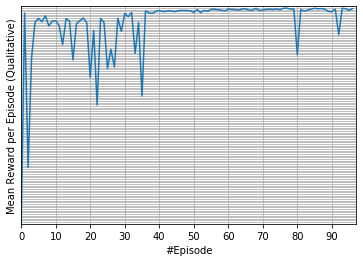

In [26]:
rewards = np.load(reward_logger.fpath)[1:] # your training rewards
plt.grid(True)
plt.xlim(0,len(rewards))
plt.ylim(min(rewards), 0)
plt.yticks(np.arange(min(rewards), 1, 1.0))
plt.tick_params(axis = 'y', left = False, labelleft = False)
plt.xticks(np.arange(0, len(rewards), 10))
plt.xlabel('#Episode')
plt.ylabel('Mean Reward per Episode (Qualitative)')
plt.plot(rewards)
plt.show()

### 4.3 Taking a Look at a Test Trajectory

You can take a look at a test trajectory to see how well your trained agent is able to control the currents to follow the test trajectory. For the agent to decide for an action given an observation you can just call its ```predict()``` function. The key deterministic is important so that the agent is not using a stochastic policy like epsilon greedy but is instead chosing an action greedily. The ```env.render()``` will then visualize the agent's and reference generator's trajectories as well as the reward.

<IPython.core.display.Javascript object>


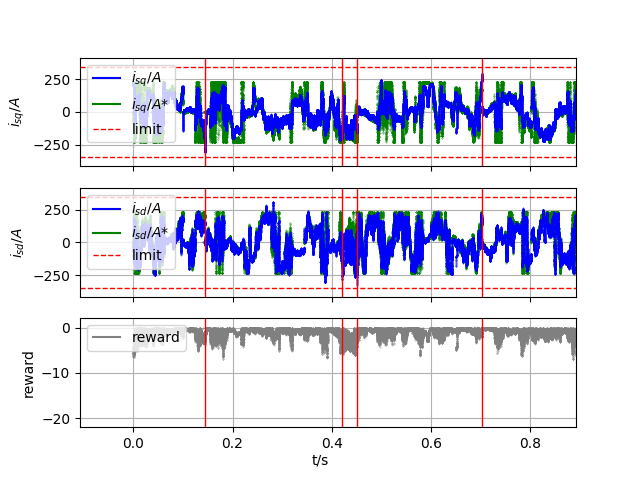

In [27]:
visualization_steps = int(9e4) # currently this crashes for larger values
obs = env.reset()
for i in range(visualization_steps):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)
    env.render()
    if done:
        obs = env.reset()

### 4.4 Calculating further evaluation parameters

With the knowledge you acquired in the previous sections you are now able to train and evaluate any in Stable-Baselines3 available reinforcement learning algorithm. The code below should give you an example how to use the trained agent to calculate a mean reward and mean episode length over a specific amount of steps. For further questions you can always have a look at the documentation of gym-electric-motor and Stable-Baselines3 or raise an issue in their respective GitHub repositories.

In [28]:
test_steps = int(1e5)
cum_rew = 0
episode_step = 0
episode_lengths = []
for i in range(test_steps):
    print(f"{i+1}", end = '\r')
    episode_step += 1
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)
    cum_rew += reward
    if done:
        episode_lengths.append(episode_step)
        episode_step = 0
        obs = env.reset()
print(f"The reward per step with {test_steps} steps was: {cum_rew/test_steps:.4f} ")
print(f"The average Episode length was: {round(np.mean(episode_lengths))} ")


The reward per step with 100000 steps was: -1.1691 
The average Episode length was: 7455.0 
